# Pretrained Networks: Cycle GAN (Generative Adversarial Network)

In this notebook we will reach the pinnacle of DeepLearning impacc, we will convert horses into zebras.

## Boilerplate from the book to create a GAN
Copy-pasta from Chapter 2 source code.

In [2]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

## Instantiate the GAN Network
This network is only a blank/random slate, we need to load the weights and put the network in `eval()` mode.

In [4]:
netG = ResNetGenerator()
netG

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

## Load the Pretrained Weights

In [5]:
model_path = '../data/ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

Put the network in eval mode:

In [6]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

## Load a Random Horse Image
We load and prepare an image for inference, in this case the inference is the transformation from a horse-like image to a zebra-like image.

In [7]:
from PIL import Image
from torchvision import transforms

We create a preprocessing function to prepare the image for inference:

In [9]:
preprocess = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])

Load the image and preprocess:

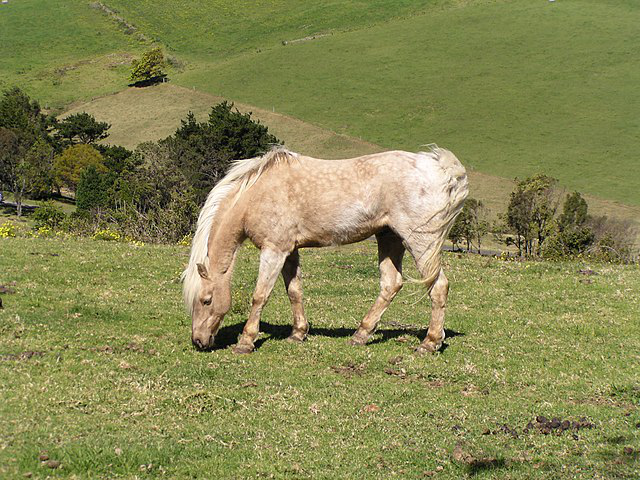

In [11]:
horse_img1 = Image.open('../data/ch2/horse1.jpg')
horse_img1

In [16]:
img1_t = preprocess(horse_img1)
img1_t

tensor([[[0.5098, 0.6941, 0.7725,  ..., 0.4667, 0.4706, 0.4667],
         [0.4902, 0.5412, 0.5098,  ..., 0.4549, 0.4510, 0.4588],
         [0.4431, 0.4510, 0.4275,  ..., 0.4314, 0.4431, 0.4549],
         ...,
         [0.4980, 0.5020, 0.5451,  ..., 0.4314, 0.3961, 0.5020],
         [0.4549, 0.4627, 0.5294,  ..., 0.3412, 0.3451, 0.3451],
         [0.4510, 0.4745, 0.4549,  ..., 0.4000, 0.3333, 0.4000]],

        [[0.5137, 0.6941, 0.7725,  ..., 0.5333, 0.5333, 0.5216],
         [0.4941, 0.5412, 0.5098,  ..., 0.5255, 0.5137, 0.5137],
         [0.5059, 0.5137, 0.4863,  ..., 0.5059, 0.5098, 0.5137],
         ...,
         [0.5294, 0.5373, 0.5882,  ..., 0.4667, 0.4196, 0.5216],
         [0.5137, 0.5216, 0.5765,  ..., 0.3882, 0.4039, 0.4000],
         [0.5255, 0.5373, 0.5020,  ..., 0.4627, 0.4039, 0.4745]],

        [[0.2824, 0.5216, 0.6706,  ..., 0.3176, 0.3216, 0.3137],
         [0.3922, 0.4941, 0.5176,  ..., 0.3059, 0.3020, 0.3059],
         [0.2627, 0.2863, 0.2745,  ..., 0.2863, 0.2941, 0.

In [18]:
batch1_t = torch.unsqueeze(img1_t, 0)
batch1_t

tensor([[[[0.5098, 0.6941, 0.7725,  ..., 0.4667, 0.4706, 0.4667],
          [0.4902, 0.5412, 0.5098,  ..., 0.4549, 0.4510, 0.4588],
          [0.4431, 0.4510, 0.4275,  ..., 0.4314, 0.4431, 0.4549],
          ...,
          [0.4980, 0.5020, 0.5451,  ..., 0.4314, 0.3961, 0.5020],
          [0.4549, 0.4627, 0.5294,  ..., 0.3412, 0.3451, 0.3451],
          [0.4510, 0.4745, 0.4549,  ..., 0.4000, 0.3333, 0.4000]],

         [[0.5137, 0.6941, 0.7725,  ..., 0.5333, 0.5333, 0.5216],
          [0.4941, 0.5412, 0.5098,  ..., 0.5255, 0.5137, 0.5137],
          [0.5059, 0.5137, 0.4863,  ..., 0.5059, 0.5098, 0.5137],
          ...,
          [0.5294, 0.5373, 0.5882,  ..., 0.4667, 0.4196, 0.5216],
          [0.5137, 0.5216, 0.5765,  ..., 0.3882, 0.4039, 0.4000],
          [0.5255, 0.5373, 0.5020,  ..., 0.4627, 0.4039, 0.4745]],

         [[0.2824, 0.5216, 0.6706,  ..., 0.3176, 0.3216, 0.3137],
          [0.3922, 0.4941, 0.5176,  ..., 0.3059, 0.3020, 0.3059],
          [0.2627, 0.2863, 0.2745,  ..., 0

In [20]:
batch1_out = netG(batch1_t)
batch1_out

tensor([[[[-3.5700e-01, -4.0519e-02,  1.7997e-01,  ..., -2.2923e-01,
           -1.7975e-01, -1.4470e-01],
          [-3.0212e-01, -2.1127e-01, -1.7793e-01,  ..., -2.3498e-01,
           -1.9436e-01, -2.0277e-01],
          [-4.2288e-01, -4.6439e-01, -5.3383e-01,  ..., -2.2773e-01,
           -2.2481e-01, -2.0176e-01],
          ...,
          [-2.4991e-01, -1.9312e-01, -8.8474e-02,  ..., -1.4866e-01,
           -2.0401e-04,  5.2090e-02],
          [-2.2537e-01, -1.6568e-01, -1.9389e-01,  ..., -1.0070e-01,
           -2.3323e-02, -4.6496e-02],
          [-1.6570e-01, -6.6063e-02, -3.9916e-02,  ..., -1.5431e-01,
           -9.2418e-02, -8.8055e-02]],

         [[-2.2261e-01,  1.9620e-01,  4.6682e-01,  ..., -1.5342e-01,
           -9.1899e-02, -5.4421e-02],
          [-1.4021e-01,  3.9472e-02,  1.1887e-01,  ..., -1.6385e-01,
           -1.3542e-01, -1.2247e-01],
          [-2.2909e-01, -2.5280e-01, -2.5308e-01,  ..., -1.3661e-01,
           -1.2813e-01, -1.0949e-01],
          ...,
     

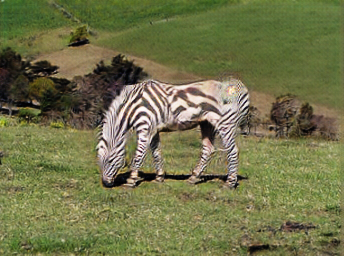

In [24]:
out1_t = (batch1_out.data.squeeze() + 1.0) / 2.0
out1_img = transforms.ToPILImage()(out1_t)
out1_img

Whoa! It works!

## Reusable Function
Let's create a reusable function to prevent too much copy-pasta.

In [27]:
def zebrazify(img):
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_out = netG(batch_t)
    out_t = (batch_out.data.squeeze() + 1.0) / 2.0
    return transforms.ToPILImage()(out_t)

## Test 1
Horse mounted by a military officer

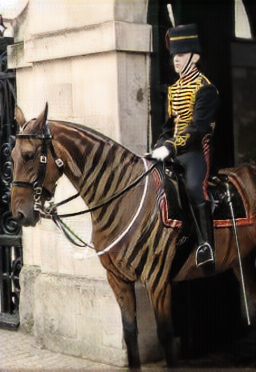

In [28]:
horse2_img = Image.open('../data/ch2/horse2.jpg')
horse2_img
zebrazify(horse2_img)

Looks more like a Quagga, but it checkes out.

## Test 2
Casual horses in a street scene.

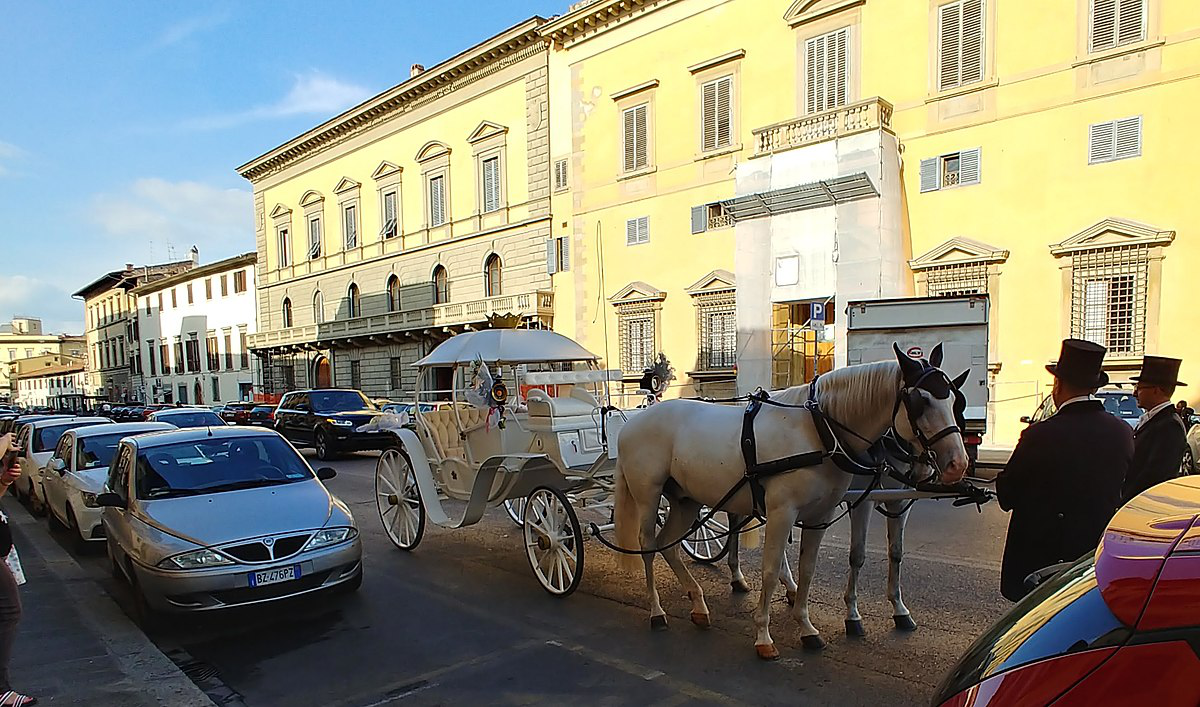

In [30]:
horse3_img = Image.open('../data/ch2/horse3.jpg')
horse3_img

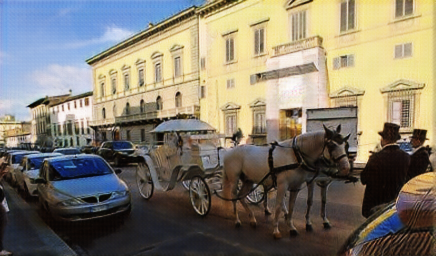

In [31]:
zebrazify(horse3_img)

Mmm, it didn't detect the horses at all, but the car was zebrazified correctly!

## Test 3
Typical cowboy scene, but with the caveat that we have a dog.

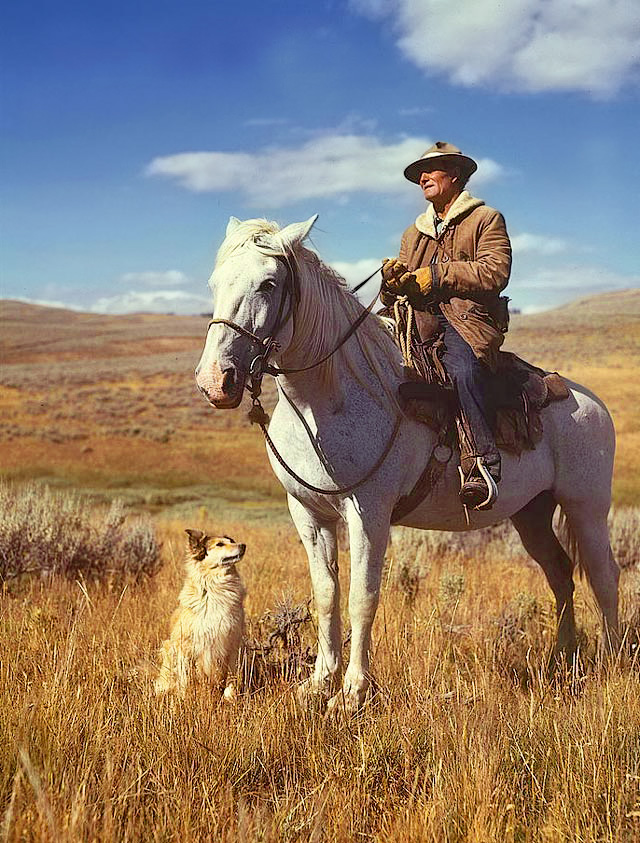

In [32]:
horse4_img = Image.open('../data/ch2/horse4.jpg')
horse4_img

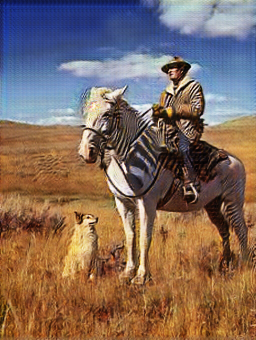

In [33]:
zebrazify(horse4_img)

Yay, it checks out, of course the cowboy had a fashion emergency too!

## Test 4
What if we run the resnet in a hand-drawn horse?

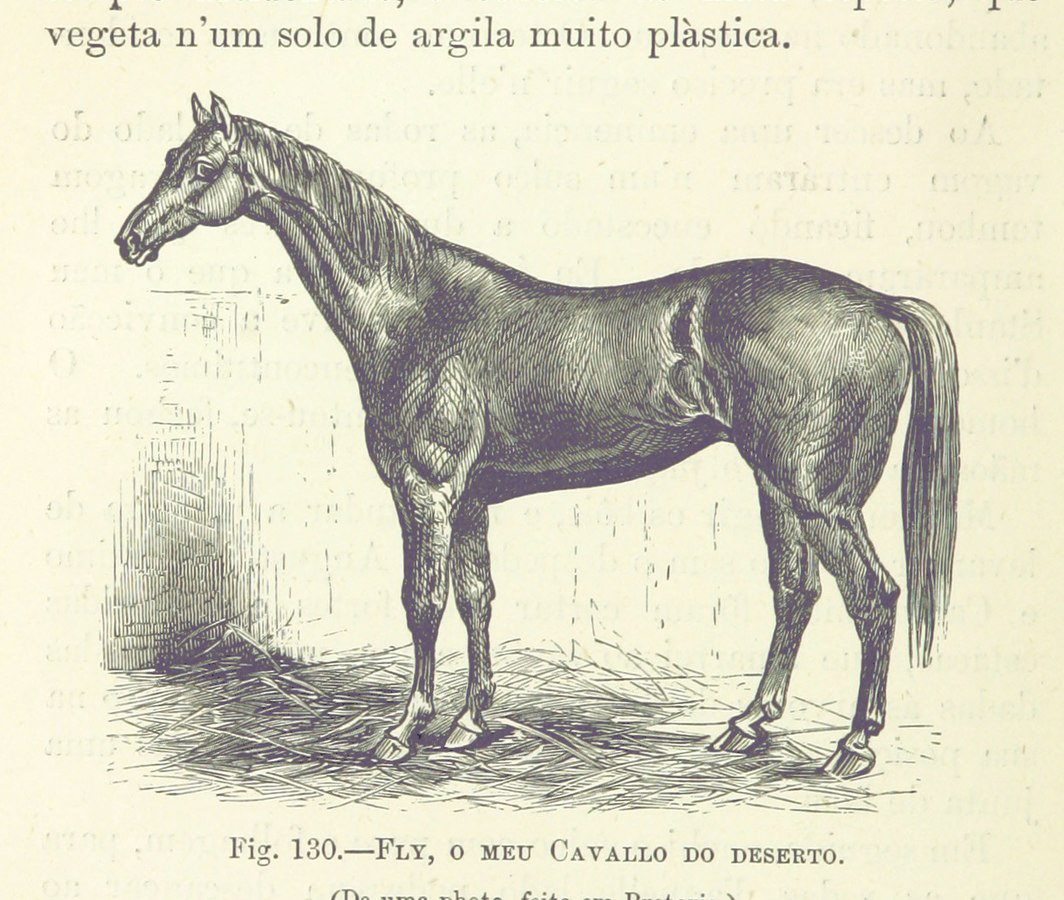

In [34]:
horse5_img = Image.open('../data/ch2/horse5.jpg')
horse5_img

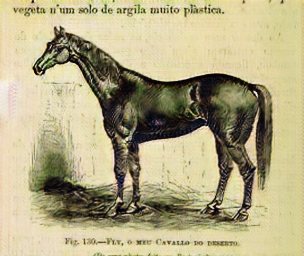

In [35]:
zebrazify(horse5_img)

Again, it cannot be use for hand-drawn images, only for photographs.

## Random Thoughts
We could use an image segmentation to extract image masks labeled with some semantic categories. Then we could use this resnet to only zebrazify the image area that has a horse in it. Then we could just replace the horse-mask with the new zebrazified area. I think this could work, but sadly the transformation changes the image histogram, so it will be really notorious that a masked area of the image was modified with an algorithm, like in a poorly photoshoped image.